<a href="https://colab.research.google.com/github/berthine/SIAM-Summer-School/blob/main/SIAM2021_RNNs_Multi_time_step_outputipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical: Time series prediction 3
(21/July/2021)

### 2021 Gene Golub SIAM Summer School 
https://sites.google.com/aims.ac.za/g2s3/home 

Instructor

<font color="green">***Dr. Emmanuel Dufourq*** 

www.emmanueldufourq.com

edufourq (['@']) gmail.com

***African Institute for Mathematical Sciences***

***Stellenbosch University***

***2021***


Material adapted from: https://www.tensorflow.org/tutorials/structured_data/time_series

Code licensed under https://www.apache.org/licenses/LICENSE-2.0



## <font color="green"> Learning outcomes:

* Multi-time step outputs

## <font color="green">Data information:

* Features: 14 real valued features

* Output: real-valued targer (temperature)

## <font color="green">Tasks for participants (boolean)?

* No, follow along and make your own modifications and make sure you understand


In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Weather dataset



This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

We will be working with time series data which orginates from here: https://www.bgc-jena.mpg.de/wetter/ first let's download a snapshot of data from 2009 to 2016. Below we extract the .zip data

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Now let's read in the .csv data using Pandas.

In [ ]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


# Preprocessing

## Hourly predictions

Slice the data to extract only every 6th record. The original data has one row for every 10 minutes.

In [ ]:
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


## Visualise all of the data for some variables

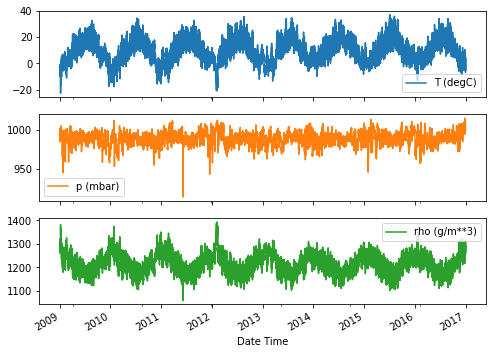

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

## Visualise some of the data for some variables

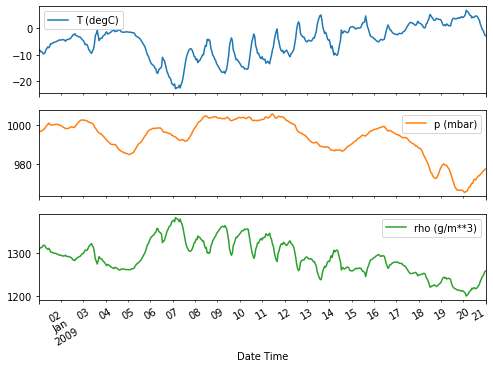

In [ ]:
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Clean up the data

More details available here: https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [ ]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,-0.855154,-0.160038,-1.336792,-0.250174,-0.953717,0.300706,0.006900,0.999976
420527,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,-0.716196,-0.726267,-1.348134,-1.367090,-0.843391,0.537300,0.007617,0.999971
420533,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,-0.661501,0.257908,-1.453438,0.566672,-0.675590,0.737277,0.008334,0.999965
420539,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,-0.280621,-0.209169,-0.545207,-0.406385,-0.461749,0.887011,0.009050,0.999959


## Split the data into training, validation and testing

We clearly split the data such that the order is preserved and such that each split is disjoint. No random shuffling like for the previous problems.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


## Normalise each split

Note how we are using the mean and sdev from the training data and applying it to the validation and testing!

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388


In [ ]:
val_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
294383,0.213759,0.618351,0.597730,1.321003,1.207707,0.407409,1.535799,-0.688716,1.526045,1.526654,-0.601703,0.072253,-0.639008,0.089478,-0.535618,0.759951,1.192787,-0.859306,-1.151853
294389,0.241478,0.545560,0.523229,1.260764,1.286231,0.321636,1.433619,-0.738532,1.424968,1.423369,-0.526259,0.071987,-0.233849,0.079109,-0.188724,1.042768,0.955490,-0.860161,-1.151299
294395,0.258351,0.510898,0.487698,1.249290,1.370796,0.282648,1.414609,-0.784197,1.406250,1.404590,-0.490612,-0.459268,0.629912,-0.526513,0.659056,1.254528,0.653085,-0.861015,-1.150745
294401,0.277634,0.487789,0.463629,1.227776,1.388917,0.256656,1.378964,-0.794575,1.368815,1.367032,-0.463755,-0.086355,-0.297434,-0.068182,-0.229261,1.380799,0.306181,-0.861869,-1.150190
294407,0.294506,0.502810,0.476236,1.255027,1.413079,0.273551,1.424114,-0.807029,1.413738,1.413979,-0.474987,-0.421783,0.109299,-0.413007,0.139150,1.412977,-0.061582,-0.862723,-1.149635


In [ ]:
test_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
378491,1.599724,-0.728855,-0.846438,-0.480418,0.821124,-0.764821,-0.633744,-0.667960,-0.656453,-0.654069,1.089310,1.623820,1.106908,1.557556,1.016688,-1.224696,0.707179,1.262942,0.511342
378497,1.653958,-0.734632,-0.856754,-0.563604,0.615753,-0.767420,-0.700280,-0.613992,-0.720093,-0.719796,1.112016,1.704558,0.855454,1.888362,0.898892,-0.999946,1.000059,1.263298,0.510397
378503,1.684087,-0.768139,-0.892285,-0.593724,0.645954,-0.788214,-0.721666,-0.626446,-0.742555,-0.743270,1.153523,1.660785,1.082109,1.443980,0.911444,-0.707046,1.224794,1.263652,0.509452
378509,1.666010,-0.829376,-0.950739,-0.542091,0.990254,-0.822003,-0.683646,-0.717775,-0.705119,-0.703364,1.205528,1.043796,1.479713,1.060063,1.414679,-0.365957,1.366069,1.264006,0.508506
378515,1.658778,-0.836308,-0.957616,-0.550696,0.990254,-0.827201,-0.690775,-0.717775,-0.712606,-0.710407,1.211876,1.804237,1.284633,1.767462,1.197013,0.000077,1.414255,1.264359,0.507561


## Class to create batches of data

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  
  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  # this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) 
  # pairs using the preprocessing.timeseries_dataset_from_array function.
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

## Using the Window Generator

The WindowGenerator allows us to create different input/output pairs so we can train different types of models. The main types are: single step and multi step. In single step we consider 1 input and 1 output. In multi step we consider variable input and output. In the examples below we will use all input features but only 1 output feature, the temperature.

### Single step window

Single step here means one input and one label. This will create pairs of data to train models on a single input and a single output. Also a single feature input and output, in this example temperature.

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

This first task is to predict temperature 1h in the future given the current value of all features. 

<center><img src="https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png">

In the previous notebook we had:

```
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window
```

now we have to shift the labels so that the labels are ahead in time. 

Take a look below, the input indices start from 0, 1, 2, ..., 23 and the labels go from 24, 25, ..., 47

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

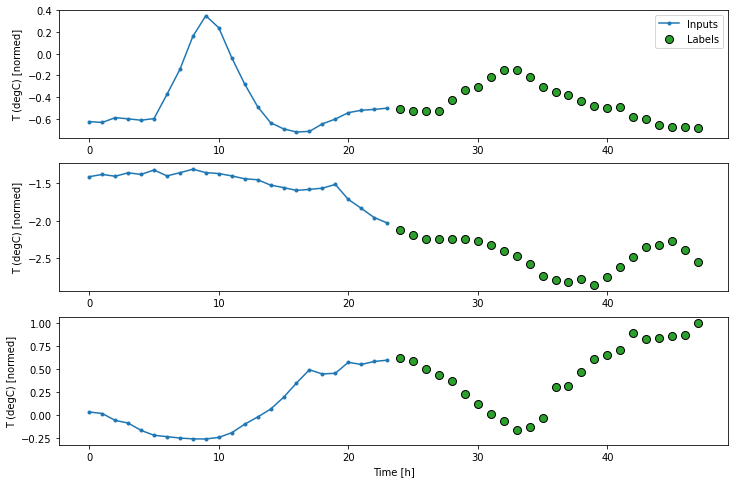

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

The ```.element_spec``` property allows us to take a look at the shapes of the window. Let's take a look below at what the shapes look like which help us decide on the network input. The shapes are in the format: (batch, time, features)

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

In [ ]:
multi_window.train.element_spec

(TensorSpec(shape=(None, 24, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 19), dtype=tf.float32, name=None))

# Comparing various models

First, let's define a function that will compile and fit any model.

In [ ]:
def compile_and_fit(model, window, patience=2):

  # Early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # Compilte the model using MSE and Adam optimiser
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  print (model.summary())

  # Train the model, her for 2 epochs
  history = model.fit(window.train, epochs=2,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## RNNS

First, let's create multi time step inputs. This is code you've seen before for plotting, but now we will use it for the model training and make some modifications. Now let's consider 24 time step inputs and 24 label outputs. Even though we create 24 hour outputs it doesn't mean we will predict 24 hours ahead. In this example we will train on 24 hours of data but only predict 1 hour ahead.

### Create a RNN model

Some differences here.

* ```return_sequences``` arguement


If you set ```return_sequences=False``` then the model only makes a prediction at the very last label.

<img src="https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png">

If you set ```return_sequences=True``` then there will be a prediction for each time stamp but this doesn't make sense for our goal, e.g. time step 0 shouldn't be used to predict a value for time step 24. Thus, it makes more sense to set return_sequences to False if we want to predict ahead of time all in one go.





Defining the model is a little more complex than before.

We know the input will be (batch, time, features). In our case (24,19) so setting ```input_shape = (24,19)``` makes sense just like before.

But now we want to predict 24 timesteps for the 19 features, so we basically are producing 24*19 outputs and then need that many output units in our last layer.

However, our output labels is also in the format (24,19) so we need to reshape out output from the last fully connected layer so match this shape. To do this, we include a Reshape layer. API for Reshape: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape

The code below won't work if we set return_sequences=True as it will return an output for each 24 time steps.

In [ ]:
multi_lstm_model = tf.keras.Sequential()
multi_lstm_model.add(tf.keras.layers.LSTM(units=32,activation='relu', input_shape = (24,19), return_sequences=False))
multi_lstm_model.add(tf.keras.layers.Dense(units=24*19, activation = 'linear'))
multi_lstm_model.add(tf.keras.layers.Reshape([24, 19]))

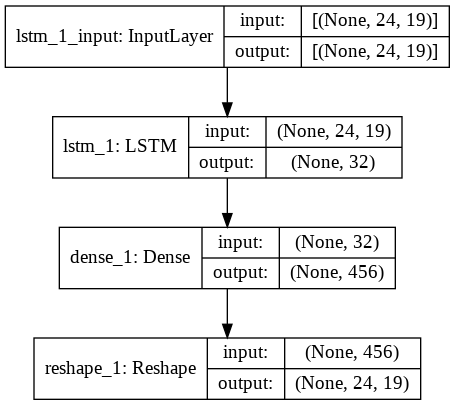

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multi_lstm_model, show_shapes=True)

### Fit the RNN model on the single step data

In [ ]:
# Compile the train the model
history = compile_and_fit(multi_lstm_model, multi_window)

# Store the performance results on the validation data
val_performance = multi_lstm_model.evaluate(multi_window.val)
performance = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                6656      
_________________________________________________________________
dense_1 (Dense)              (None, 456)               15048     
_________________________________________________________________
reshape_1 (Reshape)          (None, 24, 19)            0         
Total params: 21,704
Trainable params: 21,704
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1532/1532 [==============================] - 31s 18ms/step - loss: 0.2740 - mean_absolute_error: 0.3452 - val_loss: 0.2251 - val_mean_absolute_error: 0.3007
Epoch 2/2
437/437 [==============================] - 3s 6ms/step - loss: 0.2188 - mean_absolute_error: 0.2936


### Plot the results

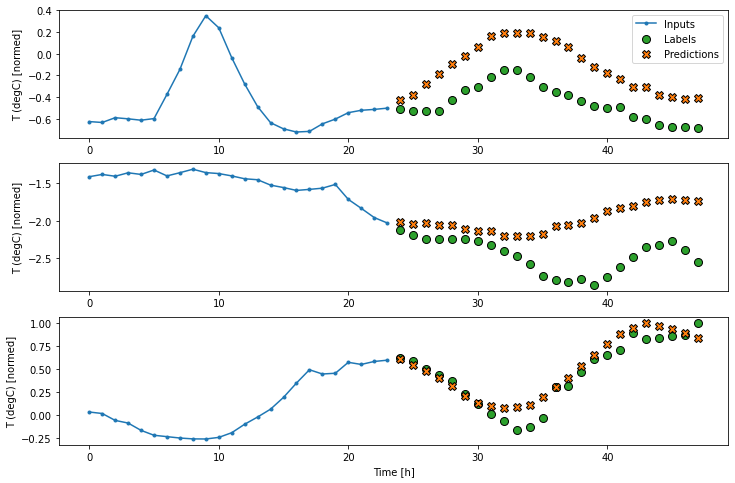

In [ ]:
multi_window.plot(multi_lstm_model)

The above approach in a "single-shot" model. The model takes in all the inputs and then makes one prediction for all the future time stamps. The alternative is predict one time step ahead and feed that output back into the model to predict another time step. 

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one. This is called autoregressive. This is more complex and left as further reading material to the reader: https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model

One clear advantage to this style of model is that it can be set up to produce output with a varying length.